**Please find the dataset here:**

https://www.kaggle.com/gunhcolab/fan-fest-20-covid-healthcare-and-economy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os, gc, cv2, math

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K

from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Concatenate, Dense, Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from skimage import io
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve, f1_score, auc, precision_score, confusion_matrix

print("Tensorflow version: " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version: 2.4.1


In [3]:
# Detecting hardware
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. 
    print('Running on TPU ', tpu.master())

except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. 

print("replicas: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.21.229.90:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.21.229.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.21.229.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


replicas:  8


In [4]:
# Optimizing Compiler 

MIX = False
XLA = False

if MIX:
    if tpu: 
      policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: 
      policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

In [5]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    
    rotation = math.pi * rotation / 180. # DEGREES TO RADIANS
    shear = math.pi * shear / 180.
    
    c1 = tf.math.cos(rotation) # ROTATION MATRIX
    s1 = tf.math.sin(rotation)
    one = tf.constant([1], dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape(tf.concat([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis = 0), [3 ,3] )
        
    c2 = tf.math.cos(shear) # SHEAR MATRIX
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one, s2, zero, zero, c2, zero, zero, zero, one], axis = 0), [3, 3])    
    
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3]) # ZOOM MATRIX
    
    shift_matrix = tf.reshape( tf.concat([one, zero, height_shift, zero, one, width_shift, zero, zero, one], axis = 0), [3, 3] ) # SHIFT MATRIX
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))
    # returns 3x3 transformed matrix which transforms indicies

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

def get_training_dataset(dataset, do_aug = True):
    if do_aug: 
        dataset = dataset.map(transform, num_parallel_calls = AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [6]:
disease_types=['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/Colab_Notebook/CovidDataset3'
train_dir = os.path.join(data_dir)

In [7]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [8]:
train

,File,DiseaseID,Disease Type
0,COVID/Covid (155).png,0,COVID
1,COVID/Covid (214).png,0,COVID
2,COVID/Covid (209).png,0,COVID
3,COVID/Covid (1232).png,0,COVID
4,COVID/Covid (1246).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (1143).png,1,non-COVID
2477,non-COVID/Non-Covid (1042).png,1,non-COVID
2478,non-COVID/Non-Covid (1068).png,1,non-COVID
2479,non-COVID/Non-Covid (1170).png,1,non-COVID


In [9]:
IMAGE_SIZE = 64
X = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values), total = len(train)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X /= 255.
y = train['DiseaseID'].values
print(X.shape)
print(y.shape)


(2481, 64, 64, 3)
(2481,)


In [10]:
from sklearn.cluster import KMeans

X0 = X[y == 0].reshape(len(X[y == 0]), -1)
X1 = X[y == 1].reshape(len(X[y == 1]), -1)

k = 50
kmeans = KMeans(k)
cluster0 = kmeans.fit_predict(X0)
cluster1 = kmeans.fit_predict(X1)
cluster1 += k
cluster = np.concatenate([cluster0, cluster1])

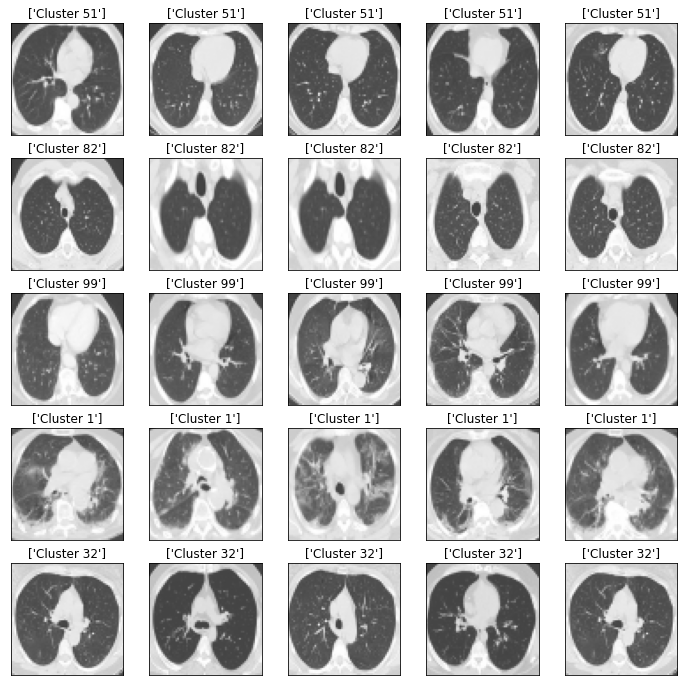

In [ ]:
np.random.seed(42)

rows = 5 
cols = 5

fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
for i in range(rows):
    clt = np.random.randint(0, 2 * k)
    clt_idx = np.random.choice(np.where(cluster == clt)[0], cols, replace = True)
    X_clt = X[clt_idx]
    for j in range(cols):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title([f'Cluster {clt}'])
        ax[i, j].imshow(X_clt[j])

In [ ]:
train_idx, val_idx = next(GroupShuffleSplit(test_size = 0.2, n_splits = 2, random_state = 42).split(X, groups = cluster))

X_train, X_val, Y_train, Y_val = X[train_idx], X[val_idx], y[train_idx], y[val_idx]

BATCH_SIZE = 32 * strategy.num_replicas_in_sync

train_dataset = get_training_dataset(tf.data.Dataset.from_tensor_slices((X_train, Y_train)))
val_dataset = get_validation_dataset(tf.data.Dataset.from_tensor_slices((X_val, Y_val)))

In [ ]:
# EfficientNet models are not applicable on Tensorflow 2.2.0 for TPU
with strategy.scope():

    if not tpu:
        net = tf.keras.applications.EfficientNetB0(include_top = False,
                                                   weights = 'imagenet',
                                                   pooling = None)
    else:
        net = tf.keras.applications.DenseNet121(include_top = False,
                                                weights = 'imagenet',
                                                pooling = None)

    inp = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Conv2D(3, (3, 3), padding = 'same')(inp)
    x = net(x)
    x1 = GlobalAveragePooling2D()(x)
    x2 = GlobalMaxPooling2D()(x)
    x = Concatenate()([x1, x2])
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(1, activation = 'sigmoid')(x)

    model = Model(inputs = inp, outputs = out)

    metric = tf.keras.metrics.AUC(name = 'auc')
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 3)    84          input_2[0][0]                    
__________________________________________________________________________________________________
densenet121 (Functional)        (None, None, None, 1 7037504     conv2d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[0][0]                
______________________________________________________________________________________________

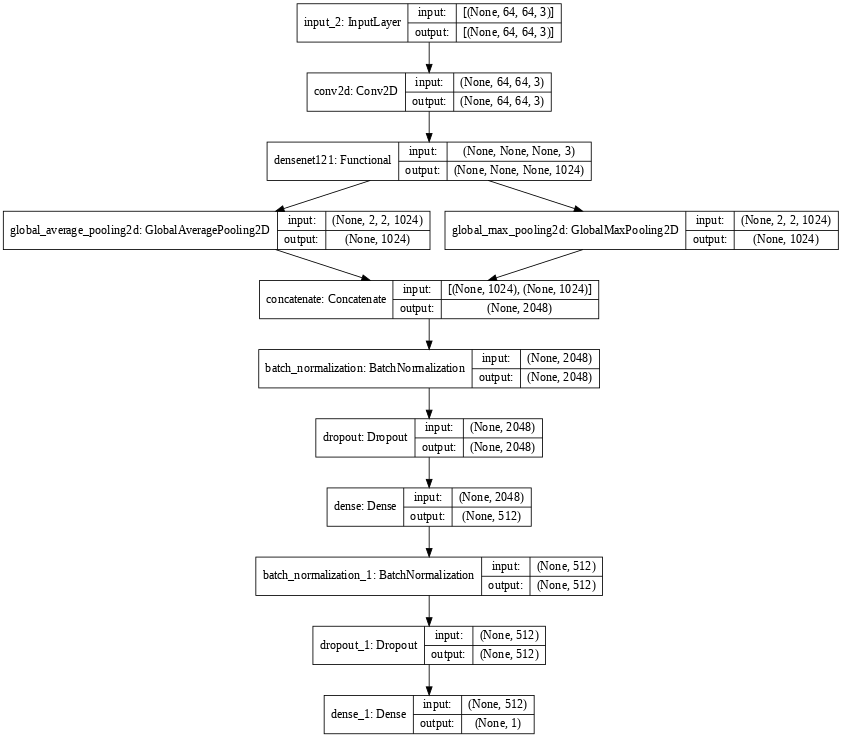

In [ ]:
plot_model(model, 
           show_shapes = True, 
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 60)

In [ ]:
# Cosine Annealing Learning Rate from 'https://github.com/4uiiurz1/keras-cosine-annealing'

class CosineAnnealingScheduler(Callback):
    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [ ]:
X_train.shape[0]

1996

In [ ]:
EPOCHS = 200

annealer = CosineAnnealingScheduler(EPOCHS, 1e-3, 1e-5)

hist = model.fit(train_dataset,
                 steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
                 epochs = EPOCHS,
                 verbose = 1,
                 callbacks = [annealer],
                 validation_data = val_dataset)

Epoch 1/200
6/7 [========================>.....] - ETA: 0s - loss: 1.0065 - auc: 0.5777WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0078s vs `on_train_batch_end` time: 6.1182s). Check your callbacks.


7/7 [==============================] - 94s 3s/step - loss: 0.9752 - auc: 0.5989 - val_loss: 8.3240 - val_auc: 0.5051
Epoch 2/200
7/7 [==============================] - 2s 273ms/step - loss: 0.7393 - auc: 0.7653 - val_loss: 4.4431 - val_auc: 0.5875
Epoch 3/200
7/7 [==============================] - 2s 272ms/step - loss: 0.6627 - auc: 0.7957 - val_loss: 5.6376 - val_auc: 0.5000
Epoch 4/200
7/7 [==============================] - 2s 265ms/step - loss: 0.5880 - auc: 0.8286 - val_loss: 12.2449 - val_auc: 0.5000
Epoch 5/200
7/7 [==============================] - 2s 265ms/step - loss: 0.5199 - auc: 0.8604 - val_loss: 8.2549 - val_auc: 0.5000
Epoch 6/200
7/7 [==============================] - 2s 268ms/step - loss: 0.5160 - auc: 0.8689 - val_loss: 9.6846 - val_auc: 0.5000
Epoch 7/200
7/7 [==============================] - 2s 351ms/step - loss: 0.4899 - auc: 0.8749 - val_loss: 1.2231 - val_auc: 0.7049
Epoch 8/200
7/7 [==============================] - 2s 266ms/step - loss: 0.4354 - auc: 0.8970 - 

Best Validation AUC:	 0.98


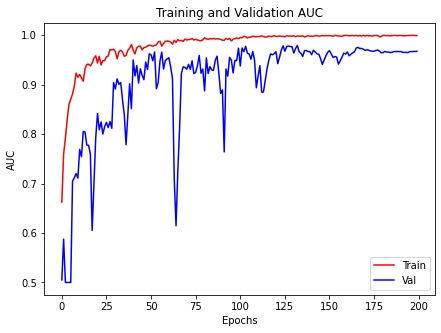

In [ ]:
# AUC score is better than accuracy if the classes are imbalanced
print('Best Validation AUC:\t', round(max(hist.history['val_auc']), 2))

auc = hist.history['auc']
val_auc = hist.history['val_auc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(auc))

plt.figure(figsize = (7, 5))
plt.title('Training and Validation AUC')
plt.plot(epochs, auc, 'r', label = 'Train')
plt.plot(epochs, val_auc, 'b', label = 'Val')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(loc = 0)
plt.show()

In [ ]:
pred_proba = model.predict(X_val)
auc_score = roc_auc_score(Y_val, pred_proba)
fpr, tpr, th = roc_curve(Y_val, pred_proba)
print('AUC Score:\t', round(auc_score, 2))

AUC Score:	 0.98


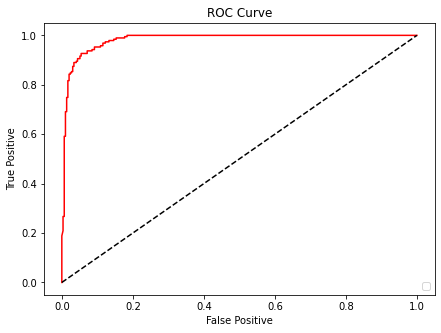

In [ ]:
plt.figure(figsize = (7, 5))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'r')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend(loc = 4)
plt.show()

In [ ]:
def threshold_optimisation(y_true, y_pred, thresholds):
    best_th = thresholds[0]
    best_acc = accuracy_score(y_true, np.where(y_pred > thresholds[0], 1, 0))
    for th in thresholds[1:]:
        acc = accuracy_score(y_true, np.where(y_pred > th, 1, 0))
        if acc > best_acc:
            best_th = th
            best_acc = acc
    return best_acc, best_th
best_acc, best_th = threshold_optimisation(Y_val, pred_proba, th)
print('Best Accuracy:\t', round(best_acc, 2))
print('Best Threshold:\t', best_th)

Best Accuracy:	 0.94
Best Threshold:	 0.99319553


[7.748604e-07]


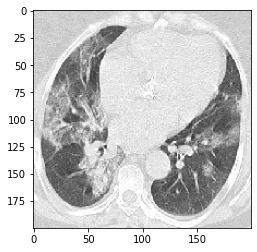

Prediction: Covid-19


In [24]:
from tensorflow.keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/Colab_Notebook/CovidDataset3/COVID/Covid (1010).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/Colab_Notebook/CovidDataset3/COVID/Covid (1010).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=int(np.round(a))
        
print('Prediction:',disease_class[ind])


[0.9998652]


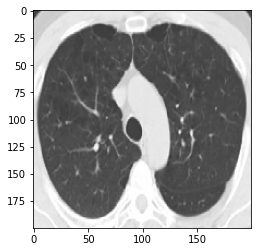

Prediction: Non Covid-19


In [26]:
# making a prediction

img = image.load_img('/content/drive/MyDrive/Colab_Notebook/CovidDataset3/non-COVID/Non-Covid (1001).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('/content/drive/MyDrive/Colab_Notebook/CovidDataset3/non-COVID/Non-Covid (1001).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=int(np.round(a))
        
print('Prediction:',disease_class[ind])

Text(0.5, 145.31999999999996, 'Predicted')

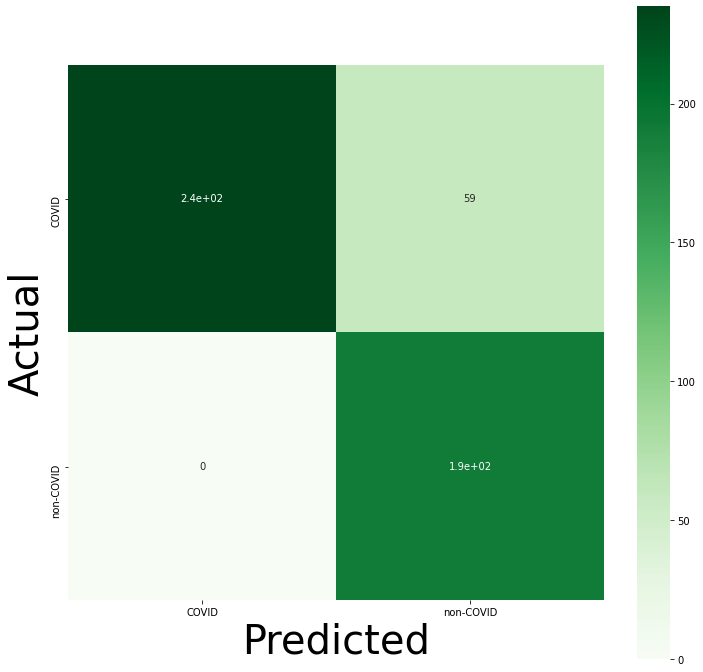

In [27]:
Y_pred = model.predict(X_val)
y_pred = []
import seaborn as sns
for i in Y_pred:
  y_pred.append(int(np.round(float(i))))

b = np.array(y_pred)

Y_true = np.argmax(Y_val)

cm = confusion_matrix(Y_val, b)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [28]:
# performance of our model

ture_negitive, false_Positive, false_negitive, true_Positive = cm.ravel()
Specificity = ture_negitive/(ture_negitive+false_Positive)
Sensitivity = true_Positive/(true_Positive+false_negitive)


print('f1 score =  %.3f'%f1_score(Y_val, np.round(Y_pred)))
print('Precision =  %.3f'%precision_score(Y_val, np.round(Y_pred)))
print('Specificity =  %.3f'%Specificity)
print('Sensitivity =  %.3f'%Sensitivity)

f1 score =  0.866
Precision =  0.764
Specificity =  0.799
Sensitivity =  1.000
